In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [2]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

# Data preparation

In [3]:
n_pop = 100000
p_male = 0.7

p_job_male, p_job_female = 0.09, 0.05

In [4]:
gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])

df = pd.DataFrame({'gender' : gender})

df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])

df['found_job'] = df['found_job'].astype(int)

In [5]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,28479,1471
male,63747,6303


In [6]:
mu_job, sigma_job = 45, 8
mu_no_job, sigma_no_job = 55, 10

In [7]:
df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))

df['age'] = df['age'].astype(int)

In [8]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,54.5
1,44.5


In [9]:
class_set = ['A', 'B', 'C']
class_wt_job = [0.4, 0.4, 0.2]
class_wt_no_job = [0.2, 0.3, 0.5]

In [10]:
df.loc[df.found_job == 1, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 1]), p=class_wt_job)
df.loc[df.found_job == 0, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 0]), p=class_wt_no_job)

In [11]:
agg_gender = df[['gender', 'found_job']].groupby('gender').mean()
agg_gender.round(3)

,found_job
gender,
female,0.049
male,0.090


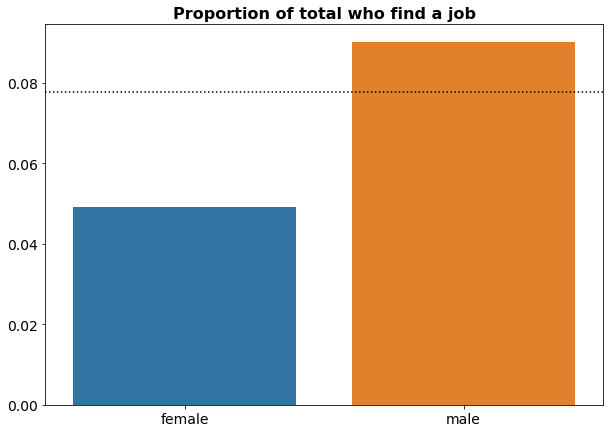

In [12]:
mean_found_job = df['found_job'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_gender.index, y=agg_gender.found_job, ax=ax1).\
set_title('Proportion of total who find a job', fontsize=16, fontweight='bold')
ax1.axhline(mean_found_job, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# Convert to AIF360 format

In [13]:
df_onehot = pd.concat([df[['found_job', 'age']], pd.get_dummies(df[['gender', 'class']])], axis=1)

In [14]:
df_onehot.head()

,found_job,age,gender_female,gender_male,class_A,class_B,class_C
0,0,49,0,1,1,0,0
1,0,53,1,0,0,0,1
2,0,66,0,1,0,0,1
3,0,48,0,1,0,0,1
4,0,44,0,1,0,1,0


In [15]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('gender_male', axis=1), label_names=['found_job'], protected_attribute_names=['gender_female'])

In [16]:
df_aif

               instance weights features                                      \
                                         protected attribute                   
                                     age       gender_female class_A class_B   
instance names                                                                 
0                           1.0     49.0                 0.0     1.0     0.0   
1                           1.0     53.0                 1.0     0.0     0.0   
2                           1.0     66.0                 0.0     0.0     0.0   
3                           1.0     48.0                 0.0     0.0     0.0   
4                           1.0     44.0                 0.0     0.0     1.0   
...                         ...      ...                 ...     ...     ...   
99995                       1.0     52.0                 1.0     0.0     0.0   
99996                       1.0     62.0                 1.0     0.0     1.0   
99997                       1.0     66.0

In [17]:
privileged_group = [{'gender_female': 0}]
unprivileged_group = [{'gender_female': 1}]

In [18]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(50000, 5), (30000, 5), (20000, 5)]


# Compute fairness metric on original dataset

In [19]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.448


# Train model on original dataset

In [20]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

In [21]:
thresh_arr = np.linspace(0.01, 0.5, 100)

In [22]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)

In [23]:
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████| 100/100 [00:01<00:00, 74.08it/s]


In [24]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.759
1-min(DI, 1/DI): 0.459


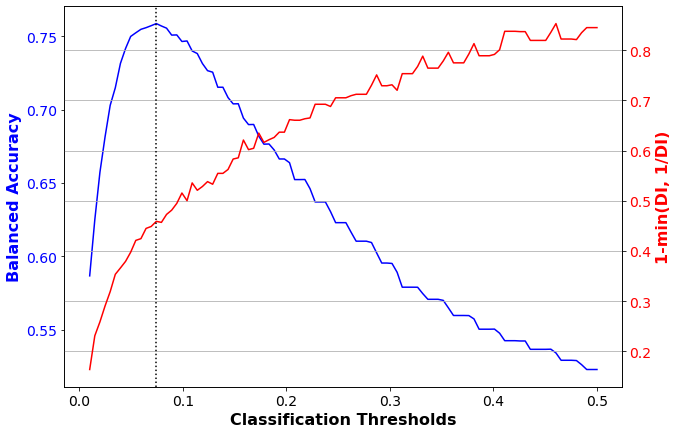

In [25]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on original dataset

In [26]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)

dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

In [27]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.75
1-min(DI, 1/DI): 0.466


# Bias mitigation

In [28]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [29]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


# Train model on transformed dataset

In [30]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [31]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)

In [32]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████| 100/100 [00:01<00:00, 74.77it/s]


In [33]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.753
1-min(DI, 1/DI): 0.062


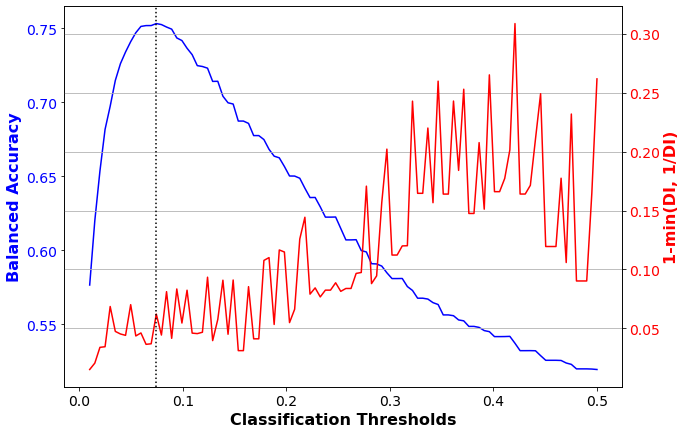

In [34]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on transformed dataset

In [35]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

In [36]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.742
1-min(DI, 1/DI): 0.068


# recruit_data

In [96]:
data = pd.read_excel('C:/Users/bbgog/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data['highest_school_level'] = data['highest_school_level'].astype('int')
data = data.drop("interview", axis=1)
data = data.drop("second_interview", axis=1)
data = data.drop("relabel", axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,relabel_check
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,N,N
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,N,N
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,N,N
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,N,N
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,N,N


In [38]:
df.head()

,gender,found_job,age,class
0,male,0,49,A
1,female,0,53,C
2,male,0,66,C
3,male,0,48,C
4,male,0,44,B


In [58]:
# 原始資料男女比
print("男性應徵人數", len(data[data['sex']=='M']))
print("女性應徵人數", len(data[data['sex']=='F']))
print("應徵人數男性占比", len(data[data['sex']=='M'])/len(data))
print("應徵人數女性占比", len(data[data['sex']=='F'])/len(data))

男性應徵人數 412
女性應徵人數 776
應徵人數男性占比 0.3468013468013468
應徵人數女性占比 0.6531986531986532


In [57]:
#原始資料男女應徵錄取情況
print("男性錄取人數", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')]))
print("男性錄取率", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='M']))
print("女性錄取人數", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')]))
print("女性錄取率", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='F']))

男性錄取人數 39
男性錄取率 0.09466019417475728
女性錄取人數 63
女性錄取率 0.08118556701030928


In [59]:
#建立資料集並設定男女比例
n_pop = 1000000
p_male = 0.35

p_job_male, p_job_female = 0.09, 0.08

In [60]:
gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])

df = pd.DataFrame({'gender' : gender})

df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])

df['found_job'] = df['found_job'].astype(int)

In [72]:
print("男性錄取率", len(df[(df['gender']=='male') & df['found_job']==1])/len(df[df['gender']=='male']))
print("女性錄取率", len(df[(df['gender']=='female') & df['found_job']==1])/len(df[df['gender']=='female']))

男性錄取率 0.089503329673307
女性錄取率 0.08041394285186297


In [73]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,597147,52218
male,319252,31383


In [75]:
mu_job, sigma_job = 28, 5
mu_no_job, sigma_no_job = 40, 5

In [76]:
df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))

df['age'] = df['age'].astype(int)

In [77]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,39.5
1,27.5


In [91]:
# 設定學歷資料
print("學士占比", len(data[data['highest_education']=='B'])/len(data))
print("學士錄取率", len(data[data['highest_education']=='B'])/len(data[(data['highest_education']=='B') & data['hired_or_not']=='Y']))
print("學士不錄取率", len(data[data['highest_education']=='B'])/len(data[(data['highest_education']=='B') & data['hired_or_not']=='N']))
print("碩士占比", len(data[data['highest_education']=='M'])/len(data))
print("碩士錄取率", len(data[data['highest_education']=='M'])/len(data[(data['highest_education']=='M') & data['hired_or_not']=='Y']))
print("碩士不錄取率", len(data[data['highest_education']=='M'])/len(data[(data['highest_education']=='M') & data['hired_or_not']=='N']))

學士占比 0.8619528619528619


C:\Users\bbgog\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


ZeroDivisionError: division by zero

In [100]:
data[(data['highest_education']=='M')]

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,relabel_check
46,F125998838,M,35,1,M,Y,1,1,1,0,187,83,1,6,3.0,N,N
51,P223902299,F,24,0,M,I,0,1,1,0,163,48,1,7,4.0,N,N
52,F228748207,F,24,0,M,I,0,1,1,0,163,47,1,6,3.0,N,N
53,E224557236,F,24,0,M,I,0,1,1,0,167,49,1,4,3.0,N,N
54,I200380062,F,23,1,M,I,0,1,1,0,168,55,1,2,2.0,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,N124436737,M,36,0,M,Y,0,1,1,0,172,69,1,4,3.0,N,N
880,T124028061,M,26,0,M,Y,0,1,1,0,166,78,1,5,2.0,N,N
881,Q123731584,M,30,0,M,Y,1,1,1,0,173,75,1,3,2.0,N,N
882,A127207442,M,32,0,M,Y,1,1,1,0,172,90,1,4,3.0,N,N


In [ ]:
class_set = [B', 'M']
class_wt_job = [0., 0.4, 0.2]
class_wt_no_job = [0.2, 0.3, 0.5]